# 📘 Tutorial PySpark: Funções de Agregação e Criação de Funções Personalizadas

## Objetivo Geral
- Apresentar os principais conceitos e ferramentas do PySpark relacionados a agrupamentos e agregações de dados.  
- Ensinar como criar funções personalizadas e aplicá-las com `groupBy`.  
- Preparar a base conceitual para cálculos como o PSI (Population Stability Index), mas com aplicabilidade mais ampla.  

---

## Sumário


1. [Preparação do Ambiente](#2-preparação-do-ambiente)
2. [Introdução ao PySpark](#1-introdução-ao-pyspark)  
3. [Exploração do Dataset](#3-exploração-do-dataset)  
4. [🔍 Agrupamentos com groupBy](#4-agrupamentos-com-groupby)  
5. [🧱 Janela e Agrupamentos Avançados](#5-janela-e-agrupamentos-avançados)  
6. [🛠️ Funções Personalizadas com UDF](#6-funções-personalizadas-com-udf)  
7. [🧪 Estudos de Caso](#7-estudos-de-caso)  
8. [📊 Exemplo Aplicado: Cálculo do PSI](#8-exemplo-aplicado-cálculo-do-psi)  
9. [🔚 Conclusões e Próximos Passos](#9-conclusões-e-próximos-passos)  

---


## 1. Preparação do Ambiente

### 1.1. Importações necessárias.


In [1]:
# Bibliotecas padrão
import numpy as np
import pandas as pd

from scipy.stats import ks_2samp

import seaborn as sns
import matplotlib.pyplot as plt

# PySpark - Sessão
from pyspark.sql import SparkSession

# PySpark - Funções
from pyspark.sql.functions import (
    concat_ws,
    avg,
    col,
    count,
    lit,
    log,
    percentile_approx,
    sum as Fsum,
    udf,
    when,
    to_date,
    lpad,
)
from pyspark.sql import functions as F

# PySpark - Tipos
from pyspark.sql.types import IntegerType, StringType, DoubleType
from pyspark.ml.feature import QuantileDiscretizer

# PySpark - Janela
from pyspark.sql.window import Window


### 1.2. Simulação de um dataset 

Iremos simular um dataset com colunas `score`, `ambiente`, `modelo`, `target`.

🎯 Objetivo:
	•	Simular dois modelos (modelo_a, modelo_b)
	•	Cada um com dados nos ambientes:
	•	DEV: 6 meses
	•	OOT: 3 meses
	•	PRD: 12 meses
	•	modelo_a permanece calibrado
	•	modelo_b vai descalibrando ao longo do tempo

⸻

📦 Etapas da simulação:
	1.	Gerar uma base com colunas: score, env, year, month, model
	2.	modelo_a: score estável em todos os ambientes
	3.	modelo_b: score muda ao longo do tempo (ex: média ou variância cresce em PRD)


In [2]:
import pandas as pd
import numpy as np

def simulate_model_data(model_name, start_year=2023):
    """
    Simula scores e variável resposta para um modelo nos ambientes DEV, OOT e PRD.
    
    - modelo_a: score calibrado e estável
    - modelo_b: score descalibrando em PRD (aumenta média ao longo do tempo)
    """
    rows = []
    rng = np.random.default_rng(seed=42 if model_name == 'modelo_a' else 99)

    def generate_block(env, year, month, loc, size=1000):
        # Gera scores com média 'loc' e desvio padrão 0.05
        scores = rng.normal(loc=loc, scale=0.05, size=size)
        scores = np.clip(scores, 0.01, 0.99)
        vr = rng.binomial(1, p=scores)
        return pd.DataFrame({
            'model': model_name,
            'env': env,
            'year': year,
            'month': month,
            'score': scores,
            'vr': vr
        })

    # Parâmetros calibrados para taxa de evento baixa (~5%)
    base_loc = 0.05
    incremento = 0.02

    # Ambiente DEV (6 meses estáveis)
    for month in range(1, 7):
        rows.append(generate_block('DEV', start_year, month, loc=base_loc))

    # Ambiente OOT (3 meses)
    for month in range(7, 10):
        loc = base_loc if model_name == 'modelo_a' else base_loc + 0.01
        rows.append(generate_block('OOT', start_year, month, loc=loc))

    # Ambiente PRD (12 meses)
    for month in range(1, 13):
        year = start_year + 1
        loc = base_loc if model_name == 'modelo_a' else base_loc + incremento * month
        rows.append(generate_block('PRD', year, month, loc=loc))

    return pd.concat(rows, ignore_index=True)

# Gerar os dados simulados
df_a = simulate_model_data('modelo_a')
df_b = simulate_model_data('modelo_b')
df = pd.concat([df_a, df_b], ignore_index=True)

# Checar taxa de eventos
taxa_eventos = df['vr'].mean()
print(f"Taxa de eventos no total: {taxa_eventos:.3%}")
print(df.head())

Taxa de eventos no total: 9.024%
      model  env  year  month     score  vr
0  modelo_a  DEV  2023      1  0.065236   0
1  modelo_a  DEV  2023      1  0.010000   0
2  modelo_a  DEV  2023      1  0.087523   0
3  modelo_a  DEV  2023      1  0.097028   0
4  modelo_a  DEV  2023      1  0.010000   0


🧪 Colunas do DataFrame final:

* model: "modelo_a" ou "modelo_b"
* env: ambiente (DEV, OOT, PRD)
* year: ano
* month: mês
* score: probabilidade estimada pelo modelo (entre 0 e 1)
* vr: variável resposta (0 ou 1), simulada com base no score

---

## 2. Introdução ao PySpark

### 2.1. Por que usar PySpark para grandes volumes de dados?

Em projetos de ciência de dados ou engenharia de dados que lidam com grandes volumes de informação (de gigabytes a terabytes ou mais), bibliotecas tradicionais como `pandas` deixam de ser eficientes, pois operam em memória (RAM) e em apenas uma máquina. Isso limita o processamento a conjuntos de dados menores e torna as operações mais lentas e sujeitas a erros de memória.

O **PySpark** é a API em Python do **Apache Spark**, um motor de processamento distribuído altamente escalável. Ele permite:

- **Processamento paralelo em cluster**: divide os dados entre várias máquinas ou núcleos.
- **Escalabilidade**: funciona localmente, em clusters locais (como com `Spark Standalone`) ou em ambientes distribuídos como Hadoop/YARN, Kubernetes, Databricks, EMR (AWS), etc.
- **Tolerância a falhas**: reexecuta automaticamente tarefas que falham.
- **Alto desempenho**: otimizado para processar dados em lote e em tempo real.

> 💡 Em resumo: PySpark permite que você escale seu código em Python para trabalhar com big data de maneira eficiente e robusta.


### 2.2. O que é o `SparkSession` e por que ele é essencial?

O `SparkSession` é a **porta de entrada** para utilizar o PySpark. Ele é o ponto central por onde você acessa todas as funcionalidades do Spark, como:

- Leitura e escrita de dados (CSV, Parquet, JSON, JDBC, etc.)
- Manipulação de DataFrames e execução de SQL
- Criação de RDDs (Resilient Distributed Datasets)
- Configuração do ambiente de execução (como número de partições, uso de cache, etc.)


In [3]:
import os
os.environ['PYSPARK_PYTHON'] = '/Users/cristianooliveira/Documents/funcoes_agregacao_pyspark/.venv/bin/python'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/Users/cristianooliveira/Documents/funcoes_agregacao_pyspark/.venv/bin/python'
spark = SparkSession.builder \
    .appName("Tutorial PySpark") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/10 21:11:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


🧠 Explicando o código:

*	.builder: inicia a configuração.
*	.appName("Tutorial PySpark"): define o nome da aplicação, útil para monitoramento.
*	.getOrCreate(): cria a sessão Spark se não existir, ou reutiliza uma existente.


📝 Nota: O objeto spark será utilizado ao longo de todo o tutorial para criar e manipular DataFrames.


### 2.3. Transformando o pandas em um dataframe do pyspark

In [ ]:
spkdf = spark.createDataFrame(df)
spkdf = spkdf.withColumn("periodo", F.concat(col("year").cast("string"), F.lit("-"), col("month").cast("string")))

---
## 3. Exploração do Dataset

- Inspeção inicial com `.show()`, `.printSchema()`, `.select()`, `.filter()`, `.distinct()`.
- Entendimento da estrutura dos dados.


In [5]:
spkdf.show(10)

+--------+---+----+-----+--------------------+---+
|   model|env|year|month|               score| vr|
+--------+---+----+-----+--------------------+---+
|modelo_a|DEV|2023|    1| 0.06523585398772157|  0|
|modelo_a|DEV|2023|    1|                0.01|  0|
|modelo_a|DEV|2023|    1| 0.08752255979032286|  0|
|modelo_a|DEV|2023|    1|  0.0970282358195607|  0|
|modelo_a|DEV|2023|    1|                0.01|  0|
|modelo_a|DEV|2023|    1|                0.01|  0|
|modelo_a|DEV|2023|    1|0.056392020158364274|  0|
|modelo_a|DEV|2023|    1| 0.03418787038282089|  0|
|modelo_a|DEV|2023|    1| 0.04915994212478556|  0|
|modelo_a|DEV|2023|    1|                0.01|  0|
+--------+---+----+-----+--------------------+---+
only showing top 10 rows



In [6]:
spkdf.printSchema()

root
 |-- model: string (nullable = true)
 |-- env: string (nullable = true)
 |-- year: long (nullable = true)
 |-- month: long (nullable = true)
 |-- score: double (nullable = true)
 |-- vr: long (nullable = true)



In [7]:
#  Select columns by different ways
spkdf.select("model","env").show(3)
spkdf.select(spkdf.model,spkdf.env).show(3)
spkdf.select(spkdf["model"],spkdf["env"]).show(3)

+--------+---+
|   model|env|
+--------+---+
|modelo_a|DEV|
|modelo_a|DEV|
|modelo_a|DEV|
+--------+---+
only showing top 3 rows

+--------+---+
|   model|env|
+--------+---+
|modelo_a|DEV|
|modelo_a|DEV|
|modelo_a|DEV|
+--------+---+
only showing top 3 rows

+--------+---+
|   model|env|
+--------+---+
|modelo_a|DEV|
|modelo_a|DEV|
|modelo_a|DEV|
+--------+---+
only showing top 3 rows



In [8]:
# By using col() function
spkdf.select(col("model"),col("env")).show(3)

# Select columns by regular expression
spkdf.select(spkdf.colRegex("`.*(mod).*`")).show(3)

#Selects columns 2 to 4  and top 3 rows
spkdf.select(spkdf.columns[2:4]).show(3)

+--------+---+
|   model|env|
+--------+---+
|modelo_a|DEV|
|modelo_a|DEV|
|modelo_a|DEV|
+--------+---+
only showing top 3 rows

+--------+
|   model|
+--------+
|modelo_a|
|modelo_a|
|modelo_a|
+--------+
only showing top 3 rows

+----+-----+
|year|month|
+----+-----+
|2023|    1|
|2023|    1|
|2023|    1|
+----+-----+
only showing top 3 rows



In [9]:
# filter
spkdf.filter(col("model") == "modelo_a").show(3)
spkdf.filter(spkdf.model == "modelo_a").show(3)
spkdf.filter("model = 'modelo_a'").show(3)

+--------+---+----+-----+-------------------+---+
|   model|env|year|month|              score| vr|
+--------+---+----+-----+-------------------+---+
|modelo_a|DEV|2023|    1|0.06523585398772157|  0|
|modelo_a|DEV|2023|    1|               0.01|  0|
|modelo_a|DEV|2023|    1|0.08752255979032286|  0|
+--------+---+----+-----+-------------------+---+
only showing top 3 rows

+--------+---+----+-----+-------------------+---+
|   model|env|year|month|              score| vr|
+--------+---+----+-----+-------------------+---+
|modelo_a|DEV|2023|    1|0.06523585398772157|  0|
|modelo_a|DEV|2023|    1|               0.01|  0|
|modelo_a|DEV|2023|    1|0.08752255979032286|  0|
+--------+---+----+-----+-------------------+---+
only showing top 3 rows

+--------+---+----+-----+-------------------+---+
|   model|env|year|month|              score| vr|
+--------+---+----+-----+-------------------+---+
|modelo_a|DEV|2023|    1|0.06523585398772157|  0|
|modelo_a|DEV|2023|    1|               0.01|  0|


In [10]:
spkdf.filter("model = 'modelo_a' AND env = 'DEV'").show(3)

+--------+---+----+-----+-------------------+---+
|   model|env|year|month|              score| vr|
+--------+---+----+-----+-------------------+---+
|modelo_a|DEV|2023|    1|0.06523585398772157|  0|
|modelo_a|DEV|2023|    1|               0.01|  0|
|modelo_a|DEV|2023|    1|0.08752255979032286|  0|
+--------+---+----+-----+-------------------+---+
only showing top 3 rows



---

## 4. Agrupamentos com `groupBy`

O método `.groupBy()` em PySpark é usado para agrupar linhas de um DataFrame com base nos valores de uma ou mais colunas, permitindo aplicar funções de agregação sobre esses grupos. Ele é equivalente ao `groupby()` do pandas, mas funciona de forma distribuída e escalável.


### 4.1. Sintaxe básica

```python
df.groupBy("coluna").agg(função_agregadora)
```

Você pode agrupar por uma ou mais colunas, e aplicar funções como `count()`, `sum()`, `avg()`, `min()`, `max()`, entre outras.



In [11]:
# Contagem de registros por model
spkdf.groupBy("model").count().show()

# Média de score por env
spkdf.groupBy("env").agg(F.avg("score")).show()

# Soma de eventos por model e env
spkdf.groupBy("model", "env").agg(F.sum("vr")).show()



+--------+-----+
|   model|count|
+--------+-----+
|modelo_a|21000|
|modelo_b|21000|
+--------+-----+

+---+--------------------+
|env|          avg(score)|
+---+--------------------+
|PRD|  0.1180247751059192|
|OOT| 0.06133385077278047|
|DEV|0.055934157757326165|
+---+--------------------+

+--------+---+-------+
|   model|env|sum(vr)|
+--------+---+-------+
|modelo_a|DEV|    349|
|modelo_a|OOT|    205|
|modelo_a|PRD|    674|
|modelo_b|DEV|    310|
|modelo_b|OOT|    206|
|modelo_b|PRD|   2046|
+--------+---+-------+



### 4.2. Agregações múltiplas com .agg({})

Você pode aplicar várias agregações ao mesmo tempo, inclusive sobre diferentes colunas:

In [12]:
spkdf.groupBy("model").agg({
    "score": "avg",
    "vr": "sum"
}).show()


+--------+--------------------+-------+
|   model|          avg(score)|sum(vr)|
+--------+--------------------+-------+
|modelo_a|0.056223241218516816|   1228|
|modelo_b| 0.12814854927037073|   2562|
+--------+--------------------+-------+




⚠️ Essa forma é mais limitada: você não pode adicionar alias com nomes personalizados.



### 4.3. Agregações múltiplas com .agg(F.func()) (forma recomendada)

A forma mais flexível é usando `F.func()` com alias (`.alias("nome_coluna")`):

In [13]:
spkdf.groupBy("model", "env").agg(
    F.avg("score").alias("media_score"),
    F.sum("vr").alias("total_eventos"),
    F.count("*").alias("quantidade_registros"),
    F.round(
        (F.sum("vr") / F.count("*")) * 100,
        2
    ).alias("exposição(%)")
).show()


+--------+---+--------------------+-------------+--------------------+------------+
|   model|env|         media_score|total_eventos|quantidade_registros|exposição(%)|
+--------+---+--------------------+-------------+--------------------+------------+
|modelo_a|DEV|0.055953284685808936|          349|                6000|        5.82|
|modelo_a|OOT|0.056341076211994884|          205|                3000|        6.83|
|modelo_a|PRD| 0.05632876073650206|          674|               12000|        5.62|
|modelo_b|DEV| 0.05591503082884339|          310|                6000|        5.17|
|modelo_b|OOT| 0.06632662533356605|          206|                3000|        6.87|
|modelo_b|PRD| 0.17972078947533635|         2046|               12000|       17.05|
+--------+---+--------------------+-------------+--------------------+------------+



### 4.4. Agrupamentos não agregativos

Você também pode usar `groupBy()` para operações que não são diretamente agregações, como `collect_list` e `collect_set`:

*	`collect_list`: junta os valores de uma coluna em listas (permite repetição).
*	`collect_set`: junta os valores sem repetir (como um set).


In [14]:
# Lista de scores por model
spkdf.groupBy("model").agg(F.collect_list("score").alias("lista_scores")).show(truncate=True)

# Conjunto único de ambientes por model
spkdf.groupBy("model").agg(F.collect_set("env").alias("ambientes_unicos")).show(3)

+--------+--------------------+
|   model|        lista_scores|
+--------+--------------------+
|modelo_a|[0.06523585398772...|
|modelo_b|[0.05412471521418...|
+--------+--------------------+

+--------+----------------+
|   model|ambientes_unicos|
+--------+----------------+
|modelo_a| [DEV, PRD, OOT]|
|modelo_b| [DEV, PRD, OOT]|
+--------+----------------+



### 4.5.Uso com `.select()` ou `.withColumn()`

Em algumas situações, você pode querer transformar os resultados do groupBy() usando .select() ou .withColumn() para criar colunas derivadas ou realizar novos cálculos.

Exemplo: criar uma nova coluna com score médio classificado

In [15]:
media_df = spkdf.groupBy("model").agg(F.avg("score").alias("media_score"))

# Adiciona uma nova coluna que classifica o score como alto ou baixo
media_df = media_df.withColumn(
    "classificacao",
    F.when(F.col("media_score") >= 0.6, "Alto").otherwise("Baixo")
)

media_df.show()

+--------+--------------------+-------------+
|   model|         media_score|classificacao|
+--------+--------------------+-------------+
|modelo_a|0.056223241218516816|        Baixo|
|modelo_b| 0.12814854927037073|        Baixo|
+--------+--------------------+-------------+




Você também pode fazer .select() para reordenar ou renomear colunas após a agregação:


In [16]:
media_df.select("model", "classificacao", "media_score").show()

+--------+-------------+--------------------+
|   model|classificacao|         media_score|
+--------+-------------+--------------------+
|modelo_a|        Baixo|0.056223241218516816|
|modelo_b|        Baixo| 0.12814854927037073|
+--------+-------------+--------------------+



In [17]:
spkdf.groupBy("model", "env") \
    .agg(F.avg("score").alias("media_score")) \
    .orderBy("model", "env") \
    .show()

+--------+---+--------------------+
|   model|env|         media_score|
+--------+---+--------------------+
|modelo_a|DEV|0.055953284685808936|
|modelo_a|OOT|0.056341076211994884|
|modelo_a|PRD| 0.05632876073650206|
|modelo_b|DEV| 0.05591503082884339|
|modelo_b|OOT| 0.06632662533356605|
|modelo_b|PRD| 0.17972078947533635|
+--------+---+--------------------+



---

## 5. Janela e Agrupamentos Avançados

### 5.1. Diferença entre groupBy e funções de janela (window functions)



Embora `groupBy()` e `window functions` (funções de janela) pareçam semelhantes à primeira vista (pois ambos trabalham com agregações), eles têm finalidades e comportamentos bem diferentes:



| Característica        | `groupBy()`                                  | Window Functions                                           |
|-----------------------|-----------------------------------------------|-------------------------------------------------------------|
| Tipo de operação      | Reduz a cardinalidade do DataFrame           | Mantém a cardinalidade (não reduz número de linhas)         |
| Retorno por linha     | Não (gera 1 linha por grupo)                 | Sim (retorna uma nova coluna com valores agregados)         |
| Exemplo de uso        | Soma total por categoria                     | Soma acumulada dentro de cada categoria                     |
| Ideal para            | Resumos agregados                            | Cálculos linha a linha dentro de grupos                     |



### 5.2. Uso de Window.partitionBy().orderBy()

As funções de janela exigem que você defina um “escopo”, ou seja, dentro de qual grupo a função deve operar. Isso é feito com partitionBy().

Você pode também ordenar os dados dentro de cada partição com orderBy() — o que é necessário para funções como rank() ou row_number().




In [18]:
janela = Window.partitionBy("model").orderBy(F.desc("score"))

spkdf.withColumn("rank_score", F.rank().over(janela)).show(5)

+--------+---+----+-----+-------------------+---+----------+
|   model|env|year|month|              score| vr|rank_score|
+--------+---+----+-----+-------------------+---+----------+
|modelo_a|PRD|2024|   11| 0.2663460370305066|  0|         1|
|modelo_a|PRD|2024|    9|  0.254396153541065|  0|         2|
|modelo_a|DEV|2023|    5|0.25129120213636325|  0|         3|
|modelo_a|PRD|2024|    2|0.22781813927750655|  0|         4|
|modelo_a|PRD|2024|    8|0.22382836775265536|  1|         5|
+--------+---+----+-----+-------------------+---+----------+
only showing top 5 rows



**Exemplo 1**: Cálculo de proporções dentro de grupos

Queremos calcular a proporção de cada linha em relação ao total do grupo (por exemplo, proporção de eventos dentro de cada modelo):

In [19]:
janela_model = Window.partitionBy("model")

spkdf.withColumn("prop_eventos_modelo", 
                F.round(
                    F.col("vr") / F.sum("vr").over(janela_model)*100, 2
                )
                ).show(5)

+--------+---+----+-----+-------------------+---+-------------------+
|   model|env|year|month|              score| vr|prop_eventos_modelo|
+--------+---+----+-----+-------------------+---+-------------------+
|modelo_a|DEV|2023|    1|0.06523585398772157|  0|                0.0|
|modelo_a|DEV|2023|    1|               0.01|  0|                0.0|
|modelo_a|DEV|2023|    1|0.08752255979032286|  0|                0.0|
|modelo_a|DEV|2023|    1| 0.0970282358195607|  0|                0.0|
|modelo_a|DEV|2023|    1|               0.01|  0|                0.0|
+--------+---+----+-----+-------------------+---+-------------------+
only showing top 5 rows



In [20]:
janela_model = Window.partitionBy("model", 'env')

spkdf.withColumn("exposicao", 
                F.round(
                    F.sum("vr").over(janela_model)/F.count("vr").over(janela_model)*100, 2
                )
                ).show(5)

+--------+---+----+-----+-------------------+---+---------+
|   model|env|year|month|              score| vr|exposicao|
+--------+---+----+-----+-------------------+---+---------+
|modelo_a|DEV|2023|    1|0.06523585398772157|  0|     5.82|
|modelo_a|DEV|2023|    1|               0.01|  0|     5.82|
|modelo_a|DEV|2023|    1|0.08752255979032286|  0|     5.82|
|modelo_a|DEV|2023|    1| 0.0970282358195607|  0|     5.82|
|modelo_a|DEV|2023|    1|               0.01|  0|     5.82|
+--------+---+----+-----+-------------------+---+---------+
only showing top 5 rows



**Exemplo 2**: Ranking por score dentro de cada modelo

Aqui usamos `row_number()` e `rank()` para identificar os maiores scores por modelo:

In [21]:
janela_ordenada = Window.partitionBy("model").orderBy(F.desc("score"))

spkdf.withColumn("posicao", F.row_number().over(janela_ordenada)).show()

+--------+---+----+-----+-------------------+---+-------+
|   model|env|year|month|              score| vr|posicao|
+--------+---+----+-----+-------------------+---+-------+
|modelo_a|PRD|2024|   11| 0.2663460370305066|  0|      1|
|modelo_a|PRD|2024|    9|  0.254396153541065|  0|      2|
|modelo_a|DEV|2023|    5|0.25129120213636325|  0|      3|
|modelo_a|PRD|2024|    2|0.22781813927750655|  0|      4|
|modelo_a|PRD|2024|    8|0.22382836775265536|  1|      5|
|modelo_a|DEV|2023|    3|0.22270232011220908|  0|      6|
|modelo_a|PRD|2024|    4| 0.2163736143214973|  0|      7|
|modelo_a|PRD|2024|   10|0.21540296625940583|  0|      8|
|modelo_a|PRD|2024|   11|0.21453484068109085|  0|      9|
|modelo_a|DEV|2023|    3|0.21355130611072948|  0|     10|
|modelo_a|PRD|2024|    5| 0.2112996562073962|  1|     11|
|modelo_a|DEV|2023|    4|0.21040804569582475|  0|     12|
|modelo_a|OOT|2023|    9|0.21001214902585322|  1|     13|
|modelo_a|PRD|2024|   10|0.20965660189008484|  0|     14|
|modelo_a|DEV|

> ⚠️ **Atenção**
> - `row_number()` dá números únicos e sequenciais (`1, 2, 3, …`)
> - `rank()` atribui a mesma posição a empates e pode pular posições (`1, 1, 3, …`)

### 5.3. Quando usar Window Functions?

Use funções de janela quando você quiser:

*	Calcular totais ou médias sem colapsar o DataFrame
*	Comparar cada linha com outras do mesmo grupo
*	Aplicar funções acumuladas, ranking, diferença entre linhas, entre outros

---


## 6. Funções Personalizadas com UDF (User Defined Functions)

Por que criar UDFs no PySpark?

Embora o PySpark ofereça diversas funções nativas (pyspark.sql.functions), em muitos cenários do mundo real precisamos aplicar regras de negócio específicas, condições complexas, ou transformações personalizadas. Para isso, usamos UDFs (User Defined Functions).

> ⚠️ **Importante**
>As UDFs não são otimizadas pelo motor Catalyst do Spark, então seu uso deve ser reservado para casos em que as funções nativas não são suficientes. Sempre que possível, prefira usar funções embutidas como `when()`, `filter()`, `withColumn()`, `expr()` etc.



### 6.1. Como criar uma UDF?

Há duas formas principais de criar uma UDF no PySpark:

✅ Forma 1: Usando o decorador @udf com tipo de retorno

✅ Forma 2: Usando `F.udf()` diretamente

In [22]:
@udf(returnType=StringType())
def categoriza_score(score):
    if score < 0.2:
        return "baixo"
    elif score < 0.5:
        return "médio"
    else:
        return "alto"


categoriza_score_udf = F.udf(
    lambda s: "baixo" if s < 0.2 else "médio" if s < 0.5 else "alto",
    returnType=StringType()
)


### 6.2. Aplicando a UDF no DataFrame

A UDF pode ser aplicada como uma nova coluna:

In [23]:
spkdf = spkdf.withColumn("categoria_score", categoriza_score(F.col("score")))
spkdf.select("score", "categoria_score").show(10)

+--------------------+---------------+
|               score|categoria_score|
+--------------------+---------------+
| 0.06523585398772157|          baixo|
|                0.01|          baixo|
| 0.08752255979032286|          baixo|
|  0.0970282358195607|          baixo|
|                0.01|          baixo|
|                0.01|          baixo|
|0.056392020158364274|          baixo|
| 0.03418787038282089|          baixo|
| 0.04915994212478556|          baixo|
|                0.01|          baixo|
+--------------------+---------------+
only showing top 10 rows



**Exemplo**: Categorizar score com base em percentis

UDFs são especialmente úteis quando queremos criar faixas dinâmicas com base em estatísticas do próprio dataset, como os quantis (percentis) do score.

In [24]:
# Passo 1: Calcular quantis de score

# Obter limites baseados nos percentis 20%, 40%, 60%, 80%
quantis = spkdf.approxQuantile(
    col="score", 
    probabilities=[0.2, 0.4, 0.6, 0.8], 
    relativeError=0.01
)
print("Quantis:", quantis)

# Passo 2: Criar função UDF com base nos quantis

limites = quantis  # lista com 4 valores

@udf(returnType=StringType())
def faixa_percentil(score):
    if score <= limites[0]:
        return "Q1"
    elif score <= limites[1]:
        return "Q2"
    elif score <= limites[2]:
        return "Q3"
    elif score <= limites[3]:
        return "Q4"
    else:
        return "Q5"

# Passo 3: Aplicar ao DataFrame

spkdf = spkdf.withColumn("faixa_percentil", faixa_percentil(F.col("score")))
spkdf.select("score", "faixa_percentil").show(5)


Quantis: [0.01999548173668604, 0.05461328000715887, 0.08789542210164754, 0.1444450508413554]
+-------------------+---------------+
|              score|faixa_percentil|
+-------------------+---------------+
|0.06523585398772157|             Q3|
|               0.01|             Q1|
|0.08752255979032286|             Q3|
| 0.0970282358195607|             Q4|
|               0.01|             Q1|
+-------------------+---------------+
only showing top 5 rows



**Comparando com uma abordagem nativa**:

Se você não precisa de quantis dinâmicos, muitas classificações podem ser feitas sem UDF. Essa abordagem é mais performática e permite que o Spark otimize o plano de execução.


In [25]:
spkdf = spkdf.withColumn(
    "score_categoria",
    when(F.col("score") < 0.2, "baixo")
    .when(F.col("score") < 0.5, "médio")
    .otherwise("alto")
)

> 💡 **Dica:**
> - **UDFs com múltiplos argumentos:**
> Você também pode usar UDFs com mais de uma coluna:

In [26]:
from pyspark.sql.types import BooleanType

@udf(BooleanType())
def is_evento_relevante(score, vr):
    return score > 0.7 and vr == 1

spkdf = spkdf.withColumn("evento_relevante", is_evento_relevante("score", "vr"))

spkdf.show(3)

+--------+---+----+-----+-------------------+---+---------------+---------------+---------------+----------------+
|   model|env|year|month|              score| vr|categoria_score|faixa_percentil|score_categoria|evento_relevante|
+--------+---+----+-----+-------------------+---+---------------+---------------+---------------+----------------+
|modelo_a|DEV|2023|    1|0.06523585398772157|  0|          baixo|             Q3|          baixo|           false|
|modelo_a|DEV|2023|    1|               0.01|  0|          baixo|             Q1|          baixo|           false|
|modelo_a|DEV|2023|    1|0.08752255979032286|  0|          baixo|             Q3|          baixo|           false|
+--------+---+----+-----+-------------------+---+---------------+---------------+---------------+----------------+
only showing top 3 rows



In [27]:
spkdf.groupBy("faixa_percentil").count().orderBy("faixa_percentil").show()

+---------------+-----+
|faixa_percentil|count|
+---------------+-----+
|             Q1| 8266|
|             Q2| 8382|
|             Q3| 8307|
|             Q4| 8354|
|             Q5| 8691|
+---------------+-----+



> 🧠 **Reflexão**: quando evitar UDFs?
>> Use UDFs com moderação, especialmente em grandes volumes de dados. Prefira:
>> * when, otherwise
>> * F.bucketizer ou F.quantileDiscretizer
>> * F.expr() com lógica SQL
>> * F.transform() e funções de arrays


### 6.3. Substituindo UDFs por Funções Nativas em PySpark

Evitar UDFs sempre que possível ajuda a:
*	Melhorar a performance (UDFs não são otimizadas pelo Catalyst).
*	Manter compatibilidade com a API SQL do Spark.
*	Reduzir erros relacionados à serialização ou tipos de dados.

**Exemplo 01:** Objetivo: classificar scores em “baixo”, “médio”, “alto”.

In [28]:
# Com UDF:
import time
@udf(StringType())
def categoria(score):
    if score < 0.2:
        return "baixo"
    elif score < 0.5:
        return "médio"
    else:
        return "alto"

start = time.time()
spkdf_udf = spkdf.withColumn("cat_udf", categoria("score"))
print("UDF:", round(time.time() - start, 3), "s")

# Com when/otherwise:

start = time.time()
spkdf_native = spkdf.withColumn(
    "cat_native",
    when(F.col("score") < 0.2, "baixo")
    .when(F.col("score") < 0.5, "médio")
    .otherwise("alto")
)
print("Native:", round(time.time() - start, 3), "s")



UDF: 0.049 s
Native: 0.047 s


In [29]:
# Substituindo UDF com Bucketizer
from pyspark.ml.feature import Bucketizer

splits = [0.0, 0.2, 0.5, 1.0]  # define os limites
bucketizer = Bucketizer(splits=splits, inputCol="score", outputCol="bucket_id")

start = time.time()
spkdf_bucket = bucketizer.transform(spkdf)
print("Bucketizer:", round(time.time() - start, 3), "s")

# Mapear o id para nomes de categoria
bucket_labels = {0.0: "baixo", 1.0: "médio", 2.0: "alto"}
spkdf_bucket = spkdf_bucket.withColumn(
    "cat_bucket",
    F.when(F.col("bucket_id") == 0.0, "baixo")
    .when(F.col("bucket_id") == 1.0, "médio")
    .otherwise("alto")
)

Bucketizer: 0.161 s


In [30]:
# Substituindo UDF com QuantileDiscretizer

from pyspark.ml.feature import QuantileDiscretizer

quant_disc = QuantileDiscretizer(
    numBuckets=5, inputCol="score", outputCol="faixa_score", relativeError=0.01
)

start = time.time()
spkdf_qdisc = quant_disc.fit(spkdf).transform(spkdf)
print("QuantileDiscretizer:", round(time.time() - start, 3), "s")

QuantileDiscretizer: 0.282 s


In [31]:
# Substituindo UDF com expr (expressão SQL)

# Objetivo: aplicar uma regra condicional complexa usando SQL:

start = time.time()
spkdf_expr = spkdf.withColumn(
    "cat_expr",
    F.expr("""
        CASE
            WHEN score < 0.2 THEN 'baixo'
            WHEN score < 0.5 THEN 'médio'
            ELSE 'alto'
        END
    """)
)
print("Expr:", round(time.time() - start, 3), "s")


Expr: 0.154 s


In [32]:
# Usando transform() e arrays para aplicar lógica a listas

# Objetivo: aplicar lógica condicional sobre arrays (útil em processamento vetorial ou cenários multilabel/multiclasse).


# Exemplo: score fictício por semana
df_array = spkdf.withColumn("score_array", F.array("score", "score"))

# Aplicar transformação no array (ex: normalizar valores)
df_array = df_array.withColumn(
    "score_array_scaled",
    F.expr("transform(score_array, x -> round(x * 100, 2))")
)

df_array.select("score_array", "score_array_scaled").show(5, truncate=False)


+------------------------------------------+------------------+
|score_array                               |score_array_scaled|
+------------------------------------------+------------------+
|[0.06523585398772157, 0.06523585398772157]|[6.52, 6.52]      |
|[0.01, 0.01]                              |[1.0, 1.0]        |
|[0.08752255979032286, 0.08752255979032286]|[8.75, 8.75]      |
|[0.0970282358195607, 0.0970282358195607]  |[9.7, 9.7]        |
|[0.01, 0.01]                              |[1.0, 1.0]        |
+------------------------------------------+------------------+
only showing top 5 rows



---

# 7. Estudos de Caso

**Exemplo 01** - Analisar o comportamento de modelos ao longo do tempo e entre ambientes é essencial para identificar problemas de desempenho, estabilidade e descalibração.


**Objetivo**
*	Criar faixas de score.
*	Calcular a proporção de eventos por faixa.
*	Comparar a distribuição entre ambientes (DEV, OOT, PRD).
*	Identificar sinais de descalibração ou deriva nos modelos.



In [33]:
spkdf_qdisc.show(5)

+--------+---+----+-----+-------------------+---+---------------+---------------+---------------+----------------+-----------+
|   model|env|year|month|              score| vr|categoria_score|faixa_percentil|score_categoria|evento_relevante|faixa_score|
+--------+---+----+-----+-------------------+---+---------------+---------------+---------------+----------------+-----------+
|modelo_a|DEV|2023|    1|0.06523585398772157|  0|          baixo|             Q3|          baixo|           false|        2.0|
|modelo_a|DEV|2023|    1|               0.01|  0|          baixo|             Q1|          baixo|           false|        0.0|
|modelo_a|DEV|2023|    1|0.08752255979032286|  0|          baixo|             Q3|          baixo|           false|        2.0|
|modelo_a|DEV|2023|    1| 0.0970282358195607|  0|          baixo|             Q4|          baixo|           false|        3.0|
|modelo_a|DEV|2023|    1|               0.01|  0|          baixo|             Q1|          baixo|           fal

In [34]:
# 1️⃣ Criar faixas de score com QuantileDiscretizer

qdisc = QuantileDiscretizer(
    numBuckets=5,
    inputCol="score",
    outputCol="faixa_score",
    relativeError=0.01
)

spkdf_qdisc = qdisc.fit(spkdf).transform(spkdf)

# Opcional: mapear ids para rótulos legíveis
faixa_labels = {0.0: 'P1 (mais baixo)', 1.0: 'P2', 2.0: 'P3', 3.0: 'P4', 4.0: 'P5 (mais alto)'}

spkdf_qdisc = spkdf_qdisc.withColumn(
    "faixa_label",
    when(F.col("faixa_score") == 0.0, "P1 (baixo)")
    .when(F.col("faixa_score") == 1.0, "P2")
    .when(F.col("faixa_score") == 2.0, "P3")
    .when(F.col("faixa_score") == 3.0, "P4")
    .otherwise("P5 (alto)")
)


# 2️⃣ Calcular a proporção de eventos por faixa e ambiente

agg = spkdf_qdisc.groupBy("model", "env", "faixa_label").agg(
    F.count("*").alias("total"),
    F.sum("vr").alias("eventos")
).withColumn(
    "proporcao_eventos", F.round(F.col("eventos") / F.col("total") * 100, 2)
)

agg.orderBy("model", "env", "faixa_label").show(truncate=False)



+--------+---+-----------+-----+-------+-----------------+
|model   |env|faixa_label|total|eventos|proporcao_eventos|
+--------+---+-----------+-----+-------+-----------------+
|modelo_a|DEV|P1 (baixo) |1623 |19     |1.17             |
|modelo_a|DEV|P2         |1625 |64     |3.94             |
|modelo_a|DEV|P3         |1422 |98     |6.89             |
|modelo_a|DEV|P4         |1156 |132    |11.42            |
|modelo_a|DEV|P5 (alto)  |174  |36     |20.69            |
|modelo_a|OOT|P1 (baixo) |791  |12     |1.52             |
|modelo_a|OOT|P2         |825  |42     |5.09             |
|modelo_a|OOT|P3         |717  |60     |8.37             |
|modelo_a|OOT|P4         |566  |69     |12.19            |
|modelo_a|OOT|P5 (alto)  |101  |22     |21.78            |
|modelo_a|PRD|P1 (baixo) |3284 |48     |1.46             |
|modelo_a|PRD|P2         |3135 |115    |3.67             |
|modelo_a|PRD|P3         |2844 |212    |7.45             |
|modelo_a|PRD|P4         |2358 |235    |9.97            

In [35]:
# 3️⃣ Comparação entre ambientes (DEV vs PRD)
# 4️⃣ Visualização com seaborn e matplotlib

# Filtrar apenas os dois ambientes para comparação:


df_plot = agg.filter(F.col("env").isin("DEV", "PRD")).toPandas()

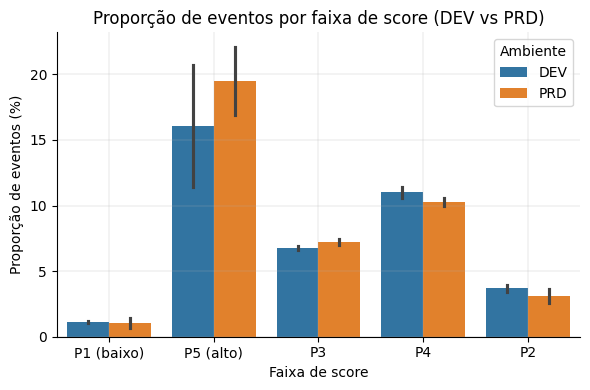

In [36]:

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(
    data=df_plot,
    x="faixa_label",
    y="proporcao_eventos",
    hue="env"
)
plt.title("Proporção de eventos por faixa de score (DEV vs PRD)")
plt.ylabel("Proporção de eventos (%)")
plt.xlabel("Faixa de score")
plt.legend(title="Ambiente")
# Ajustando a estética
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(True, linestyle='-', linewidth=0.2)
ax.xaxis.grid(True, linestyle='-', linewidth=0.2)
plt.tight_layout()
plt.show()

🔍 Interpretação

Esse tipo de gráfico é útil para:

*	Avaliar mudanças na taxa de eventos por faixa de score entre ambientes.
*	Detectar deriva nos dados ou na pontuação do modelo:
*	Se a proporção de eventos em faixas altas aumentar muito no PRD, pode ser sinal de descalibração.
*	Diferenças entre DEV e PRD indicam instabilidade do modelo ou mudança no perfil dos dados.


**Exemplo 02** - Estudo com Faixas Fixas baseadas no Ambiente DEV.

Agora vamos construir um estudo onde:

*	Usamos todo o ambiente DEV como referência estática.
*	Definimos quintis fixos (5 faixas de score) com base nos percentis do DEV.
*	Estimamos a proporção de eventos por faixa em cada mês fora de DEV (OOT e PRD).
*	Essa abordagem é ideal para estabilidade de características e monitoramento de performance fora da amostra.



In [63]:
spkdf = spark.createDataFrame(df)
spkdf = spkdf.withColumn("periodo", F.concat(col("year").cast("string"), F.lit("-"), col("month").cast("string")))

In [74]:
spkdf = spark.createDataFrame(df)
spkdf = spkdf.withColumn("periodo", F.concat(col("year").cast("string"), F.lit("-"), col("month").cast("string")))

# 📌 Número de faixas
n_faixas_score = 5
quantis = [i / n_faixas_score for i in range(1, n_faixas_score)]


# ⚠️ Use uma única chamada para calcular todos os quantis
df_dev_cuts = (
    spkdf.filter(F.col("env") == "DEV")
    .groupBy("model")
    .agg(F.percentile_approx("score", quantis, 10000).alias("cuts_score"))
)
spkdf = spkdf.join(df_dev_cuts, on="model", how="left")
# UDF para determinar a faixa de score com base na lista de cuts
def definir_faixa(score, cuts):
    if cuts is None:
        return None
    for i, limite in enumerate(cuts):
        if score <= limite:
            return i + 1
    return len(cuts) + 1  # Última faixa

faixa_udf = udf(definir_faixa, IntegerType())

# Aplicar a UDF para criar a coluna faixa_score
spkdf = spkdf.withColumn("faixa_score", faixa_udf(F.col("score"), F.col("cuts_score")))

janela_periodo = Window.partitionBy("model", "periodo")

spkdf_faixas_score = spkdf\
    .groupBy("model", "env", "periodo", "faixa_score")\
    .agg(
        F.count("*").alias("count_por_faixa"),
        F.sum("vr").alias("eventos_por_faixa")
    ).withColumn(
        "count_por_periodo", 
        F.sum("count_por_faixa").over(janela_periodo)
    ).withColumn(
    "risco_faixa", 
    F.round(F.col("eventos_por_faixa") / F.col("count_por_faixa") * 100, 2)
    ).withColumn(
    "taxa_evento_por_faixa", 
    F.round(F.col("eventos_por_faixa") / F.col("count_por_periodo") * 100, 2)
    ).withColumn(
    "taxa_obs_por_faixa", 
    F.round(F.col("count_por_faixa") / F.col("count_por_periodo") * 100, 2)
    ).orderBy(
        "model", "periodo", "faixa_score"
    )

spkdf_faixas_score.show()

+--------+---+-------+-----------+---------------+-----------------+-----------------+-----------+---------------------+------------------+
|   model|env|periodo|faixa_score|count_por_faixa|eventos_por_faixa|count_por_periodo|risco_faixa|taxa_evento_por_faixa|taxa_obs_por_faixa|
+--------+---+-------+-----------+---------------+-----------------+-----------------+-----------+---------------------+------------------+
|modelo_a|DEV| 2023-1|          1|            228|                5|             1000|       2.19|                  0.5|              22.8|
|modelo_a|DEV| 2023-1|          2|            173|                5|             1000|       2.89|                  0.5|              17.3|
|modelo_a|DEV| 2023-1|          3|            201|               10|             1000|       4.98|                  1.0|              20.1|
|modelo_a|DEV| 2023-1|          4|            212|               14|             1000|        6.6|                  1.4|              21.2|
|modelo_a|DEV| 2023-

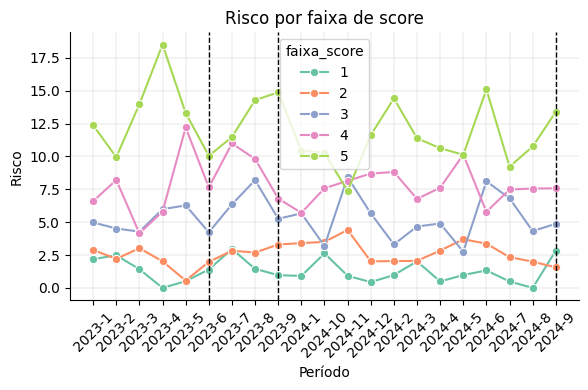

In [83]:
# 4️⃣ Visualizar com gráfico de linhas multiplas
# Vamos focar no modelo_a com faixas fixas:

# converter para Pandas para visualização
df_fixas_plot = spkdf_faixas_score.filter(
    (F.col("model") == "modelo_a")
).toPandas()

end_dev = df_fixas_plot.query("env=='DEV'")["periodo"].max()
end_prd = df_fixas_plot.query("env=='PRD'")["periodo"].max()
end_oot  = df_fixas_plot.query("env=='OOT'")["periodo"].max()
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(
    data=df_fixas_plot,
    x="periodo",
    y="risco_faixa",
    hue="faixa_score",
    palette="Set2",
    marker="o",
    ax=ax,
)
# Adicionando as linhas verticais
ax.axvline(x=end_dev, color='black', linestyle='--', linewidth=1)
ax.axvline(x=end_prd, color='black', linestyle='--', linewidth=1)
ax.axvline(x=end_oot, color='black', linestyle='--', linewidth=1)
ax.set_title("Risco por faixa de score")
ax.set_xlabel("Período")
ax.set_ylabel("Risco")
# Ajustando a estética
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(True, linestyle='-', linewidth=0.2)
ax.xaxis.grid(True, linestyle='-', linewidth=0.2)

ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


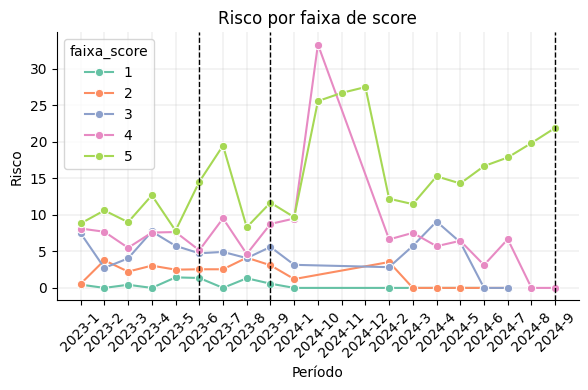

In [82]:
# 4️⃣ Visualizar com gráfico de linhas multiplas
# Vamos focar no modelo_a com faixas fixas:

# converter para Pandas para visualização
df_fixas_plot = spkdf_faixas_score.filter(
    (F.col("model") == "modelo_b")
).toPandas()

end_dev = df_fixas_plot.query("env=='DEV'")["periodo"].max()
end_prd = df_fixas_plot.query("env=='PRD'")["periodo"].max()
end_oot  = df_fixas_plot.query("env=='OOT'")["periodo"].max()
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(
    data=df_fixas_plot,
    x="periodo",
    y="risco_faixa",
    hue="faixa_score",
    palette="Set2",
    marker="o",
    ax=ax,
)
# Adicionando as linhas verticais
ax.axvline(x=end_dev, color='black', linestyle='--', linewidth=1)
ax.axvline(x=end_prd, color='black', linestyle='--', linewidth=1)
ax.axvline(x=end_oot, color='black', linestyle='--', linewidth=1)
ax.set_title("Risco por faixa de score")
ax.set_xlabel("Período")
ax.set_ylabel("Risco")
# Ajustando a estética
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(True, linestyle='-', linewidth=0.2)
ax.xaxis.grid(True, linestyle='-', linewidth=0.2)

ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


🔍 Interpretação

*	Essa abordagem permite ver se as mesmas faixas de score (definidas no DEV) mantêm a mesma taxa de eventos ao longo do tempo.
*	Se a faixa 5 (alta probabilidade de evento) começa a ter menos eventos, pode ser um sinal de descalibração ou mudança no perfil dos dados.



---

## 8. Exemplo Aplicado

### 8.1. Cálculo do PSI (Population Stability Index)


**O que é o PSI?**

O Population Stability Index (PSI) é uma métrica usada para medir mudanças na distribuição de uma variável entre dois conjuntos de dados — tipicamente entre:

*	Treinamento (ex: ambiente DEV).
*	Produção (PRD) ou fora da amostra (OOT).

Se a distribuição muda significativamente, o modelo pode estar descalibrado ou não generalizando bem.


**Fórmula do PSI**

Para cada faixa de score:

$$PSI_i = (p_i - q_i) \cdot \ln \left(\frac{p_i}{q_i} \right)$$

*	$p_i$: proporção na referência (ex: DEV).
*	$q_i$: proporção no conjunto atual (ex: PRD).
*	$PSI$ final: soma de todos os $PSI_i$.


Etapas para o cálculo no PySpark:


In [91]:
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.functions import when

# 📌 Número de faixas desejadas
n_faixas_score = 5

# 1️⃣ Gerar pontos de corte com base nos percentis do DEV
# Exemplo: [0.2, 0.4, 0.6, 0.8] se n_faixas_score = 5
quantiles = [i / n_faixas_score for i in range(1, n_faixas_score)]
cuts = spkdf.filter(F.col("env") == "DEV").approxQuantile("score", quantiles, 0.001)

# 2️⃣ Criar coluna de faixa de score dinamicamente
cond = when(F.col("score") <= cuts[0], 1)
for i in range(1, len(cuts)):
    cond = cond.when((F.col("score") > cuts[i - 1]) & (F.col("score") <= cuts[i]), i + 1)
cond = cond.otherwise(n_faixas_score)

spkdf = spkdf.withColumn("faixa_score", cond)

# 3️⃣ Distribuição em DEV (referência)
base_ref = (
    spkdf.filter(F.col("env") == "DEV")
    .groupBy("model", "faixa_score")
    .agg(F.count("*").alias("total_dev"))
)

total_dev = (
    spkdf.filter(F.col("env") == "DEV")
    .groupBy("model")
    .agg(F.count("*").alias("total_dev_model"))
)

# 4️⃣ Distribuição mensal fora do DEV
base_cmp = (
    spkdf.filter(F.col("env") != "DEV")
    .groupBy("model", "year", "month", "faixa_score")
    .agg(F.count("*").alias("total_mes"))
)

total_mes = (
    spkdf.filter(F.col("env") != "DEV")
    .groupBy("model", "year", "month")
    .agg(F.count("*").alias("total_mes_model"))
)

# 5️⃣ Juntar tudo
psi_df = (
    base_cmp
    .join(base_ref, on=["model", "faixa_score"], how="left")
    .join(total_dev, on="model", how="left")
    .join(total_mes, on=["model", "year", "month"], how="left")
    .fillna(0)
)

# 6️⃣ Calcular proporções e evitar divisão por zero
psi_df = psi_df.withColumn("p_dev", F.col("total_dev") / F.col("total_dev_model"))
psi_df = psi_df.withColumn("p_mes", F.col("total_mes") / F.col("total_mes_model"))
psi_df = psi_df.withColumn("p_dev", F.when(F.col("p_dev") == 0, 1e-6).otherwise(F.col("p_dev")))
psi_df = psi_df.withColumn("p_mes", F.when(F.col("p_mes") == 0, 1e-6).otherwise(F.col("p_mes")))

# 7️⃣ Calcular PSI
psi_df = psi_df.withColumn(
    "psi_faixa",
    (F.col("p_mes") - F.col("p_dev")) * F.log(F.col("p_mes") / F.col("p_dev"))
)

# 8️⃣ Agrupar PSI por mês
psi_mensal = (
    psi_df.groupBy("model", "year", "month")
    .agg(F.round(F.sum("psi_faixa"), 4).alias("psi_total"))
    .orderBy("model", "year", "month")
)

psi_mensal.show(truncate=False)

+--------+----+-----+---------+
|model   |year|month|psi_total|
+--------+----+-----+---------+
|modelo_a|2023|7    |0.0082   |
|modelo_a|2023|8    |0.0025   |
|modelo_a|2023|9    |0.0026   |
|modelo_a|2024|1    |0.0019   |
|modelo_a|2024|2    |0.0042   |
|modelo_a|2024|3    |0.0017   |
|modelo_a|2024|4    |0.0022   |
|modelo_a|2024|5    |0.0053   |
|modelo_a|2024|6    |0.0046   |
|modelo_a|2024|7    |0.0053   |
|modelo_a|2024|8    |0.0088   |
|modelo_a|2024|9    |3.0E-4   |
|modelo_a|2024|10   |0.0067   |
|modelo_a|2024|11   |0.0065   |
|modelo_a|2024|12   |0.0028   |
|modelo_b|2023|7    |0.0504   |
|modelo_b|2023|8    |0.0531   |
|modelo_b|2023|9    |0.0658   |
|modelo_b|2024|1    |0.1138   |
|modelo_b|2024|2    |0.5564   |
+--------+----+-----+---------+
only showing top 20 rows



In [92]:
psi_mensal = psi_mensal.withColumn(
    "periodo",
    to_date(concat_ws("-", 
                    col("year").cast("string"), 
                    lpad(col("month").cast("string"), 2, "0")), 
            "yyyy-MM")
)
psi_mensal.limit(10).show()

+--------+----+-----+---------+----------+
|   model|year|month|psi_total|   periodo|
+--------+----+-----+---------+----------+
|modelo_a|2023|    7|   0.0082|2023-07-01|
|modelo_a|2023|    8|   0.0025|2023-08-01|
|modelo_a|2023|    9|   0.0026|2023-09-01|
|modelo_a|2024|    1|   0.0019|2024-01-01|
|modelo_a|2024|    2|   0.0042|2024-02-01|
|modelo_a|2024|    3|   0.0017|2024-03-01|
|modelo_a|2024|    4|   0.0022|2024-04-01|
|modelo_a|2024|    5|   0.0053|2024-05-01|
|modelo_a|2024|    6|   0.0046|2024-06-01|
|modelo_a|2024|    7|   0.0053|2024-07-01|
+--------+----+-----+---------+----------+



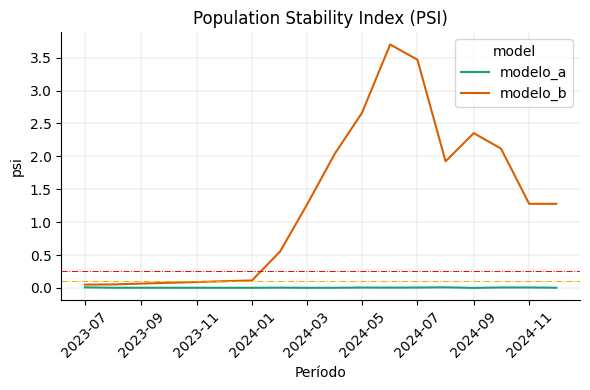

In [93]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(
    data=psi_mensal.toPandas(),
    x="periodo",
    y="psi_total",
    hue="model",
    palette="Dark2",
    ax=ax,
)
# Adicionando as linhas verticais
ax.axhline(y=0.1, color='orange', linestyle='-.', linewidth=0.7)
ax.axhline(y=0.25, color='red', linestyle='-.', linewidth=0.7)
ax.set_title("Population Stability Index (PSI)")
ax.set_xlabel("Período")
ax.set_ylabel("psi")
# Ajustando a estética
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(True, linestyle='-', linewidth=0.2)
ax.xaxis.grid(True, linestyle='-', linewidth=0.2)

ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


**Interpretação dos valores**

PSI	Interpretação
*	< 0.1	Estável
*	0.1 – 0.25	Pequena mudança
*	\> 0.25	Mudança significativa



**Comentários sobre performance e escalabilidade**

* PySpark permite escalar o PSI para bilhões de registros, com uso eficiente de .groupBy(), .agg() e joins.
* Evite collect() ou .toPandas() para cálculos pesados — apenas na visualização.
* UDFs não são necessárias para o cálculo do PSI — use funções nativas sempre que possível.
* A definição das faixas é um ponto crítico. Você pode testar:
* Faixas fixas com percentis (approxQuantile)
* Faixas customizadas (Bucketizer, QuantileDiscretizer)
* Faixas dinâmicas com ntile (menos recomendado para PSI)



### 8.2. Cálculo do KS Test (Kolmogorov-Smirnov)

Objetivo: comparar a distribuição do score entre eventos (vr=1) e não-eventos (vr=0) dentro de cada mês, medindo o poder discriminativo do modelo ao longo do tempo.

Passos:

* 1.	Criar a coluna periodo (caso ainda não tenha).
* 2.	Para cada mês (periodo), calcular a distribuição cumulativa dos scores para vr=1 e vr=0.
* 3.	Calcular a diferença máxima entre essas duas distribuições — o KS.




In [94]:
spkdf = spkdf.withColumn(
    "periodo",
    to_date(concat_ws("-", 
                    col("year").cast("string"), 
                    lpad(col("month").cast("string"), 2, "0")), 
            "yyyy-MM")
)

In [95]:
spkdf.limit(3).show()

+--------+---+----+-----+-------------------+---+---------------+---------------+---------------+----------------+-----------+----------+
|   model|env|year|month|              score| vr|categoria_score|faixa_percentil|score_categoria|evento_relevante|faixa_score|   periodo|
+--------+---+----+-----+-------------------+---+---------------+---------------+---------------+----------------+-----------+----------+
|modelo_a|DEV|2023|    1|0.06523585398772157|  0|          baixo|             Q3|          baixo|           false|          4|2023-01-01|
|modelo_a|DEV|2023|    1|               0.01|  0|          baixo|             Q1|          baixo|           false|          1|2023-01-01|
|modelo_a|DEV|2023|    1|0.08752255979032286|  0|          baixo|             Q3|          baixo|           false|          4|2023-01-01|
+--------+---+----+-----+-------------------+---+---------------+---------------+---------------+----------------+-----------+----------+



In [106]:

# 1. Criar colunas para evento e não evento
df = spkdf.withColumn("event", F.when(F.col("vr") == 1, 1).otherwise(0)) \
        .withColumn("non_event", F.when(F.col("vr") == 0, 1).otherwise(0))

# 2. Janelas para agrupamento por model, periodo e ordenação pelo score decrescente
w_group = Window.partitionBy("model", "periodo")
w_order = w_group.orderBy(F.desc("score")).rowsBetween(Window.unboundedPreceding, 0)

# 3. Total de eventos e não eventos por grupo
totals = df.groupBy("model", "periodo").agg(
    F.sum("event").alias("total_events"),
    F.sum("non_event").alias("total_non_events"),
)

df = df.join(totals, on=["model", "periodo"], how="left")

# 4. Cálculo acumulado (CDF) eventos e não eventos por score decrescente
df = df.withColumn("cum_events", F.sum("event").over(w_order)) \
    .withColumn("cum_non_events", F.sum("non_event").over(w_order))

# 5. Distribuição acumulada normalizada (CDF)
df = df.withColumn("cdf_events", F.col("cum_events") / F.col("total_events")) \
    .withColumn("cdf_non_events", F.col("cum_non_events") / F.col("total_non_events"))

# 6. Diferença absoluta entre as duas CDFs
df = df.withColumn("diff_cdf", F.abs(F.col("cdf_events") - F.col("cdf_non_events")))

# 7. KS por grupo é o máximo da diferença das CDFs
ks_df = df.groupBy("model", "periodo").agg(
    F.max("diff_cdf").alias("ks_statistic")
).orderBy("model", "periodo")

ks_df.show()

+--------+----------+-------------------+
|   model|   periodo|       ks_statistic|
+--------+----------+-------------------+
|modelo_a|2023-01-01| 0.3023571654480847|
|modelo_a|2023-02-01| 0.2919188861985472|
|modelo_a|2023-03-01|0.34169100941252833|
|modelo_a|2023-04-01| 0.4454285899682045|
|modelo_a|2023-05-01| 0.4059580913910628|
|modelo_a|2023-06-01| 0.3368421052631579|
|modelo_a|2023-07-01| 0.2808305738190078|
|modelo_a|2023-08-01| 0.3476154340085226|
|modelo_a|2023-09-01|0.36725427350427353|
|modelo_a|2024-01-01|0.34201557935735155|
|modelo_a|2024-02-01| 0.4633635363745875|
|modelo_a|2024-03-01| 0.3195129590478428|
|modelo_a|2024-04-01| 0.3427687730013312|
|modelo_a|2024-05-01|0.35411434205875236|
|modelo_a|2024-06-01|0.32900041135335256|
|modelo_a|2024-07-01| 0.3359564638634406|
|modelo_a|2024-08-01|0.41110324255885317|
|modelo_a|2024-09-01|0.33404255319148934|
|modelo_a|2024-10-01| 0.2822336561743341|
|modelo_a|2024-11-01|0.25443247567487115|
+--------+----------+-------------

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, DateType
from scipy.stats import ks_2samp

# Coletar os dados agrupados
grouped_data = spkdf.select("model", "periodo", "vr", "score").groupBy("model", "periodo").agg(
    F.collect_list("vr").alias("vr_list"),
    F.collect_list("score").alias("score_list")
).collect()

ks_results = []
for row in grouped_data:
    vr_list = row["vr_list"]
    score_list = row["score_list"]
    
    score_0 = [s for v, s in zip(vr_list, score_list) if v == 0]
    score_1 = [s for v, s in zip(vr_list, score_list) if v == 1]
    
    if len(score_0) == 0 or len(score_1) == 0:
        ks_value = None
    else:
        ks_value, _ = ks_2samp(score_0, score_1)
        ks_value = float(ks_value)  # 👈 conversão importante aqui

    ks_results.append((row["model"], row["periodo"], ks_value))

# Criar DataFrame com schema
schema = StructType([
    StructField("model", StringType(), True),
    StructField("periodo", DateType(), True),
    StructField("ks", DoubleType(), True)
])

ks_df = spark.createDataFrame(ks_results, schema=schema)
ks_df.orderBy("model", "periodo").show()

+--------+----------+-------------------+
|   model|   periodo|                 ks|
+--------+----------+-------------------+
|modelo_a|2023-01-01|0.30235716544808466|
|modelo_a|2023-02-01| 0.2919188861985472|
|modelo_a|2023-03-01| 0.3416910094125284|
|modelo_a|2023-04-01| 0.4454285899682045|
|modelo_a|2023-05-01|0.40595809139106287|
|modelo_a|2023-06-01| 0.3368421052631579|
|modelo_a|2023-07-01|0.28083057381900783|
|modelo_a|2023-08-01| 0.3476154340085226|
|modelo_a|2023-09-01|0.36725427350427353|
|modelo_a|2024-01-01| 0.3420155793573515|
|modelo_a|2024-02-01|0.46336353637458755|
|modelo_a|2024-03-01|0.31951295904784277|
|modelo_a|2024-04-01|0.34276877300133113|
|modelo_a|2024-05-01| 0.3541143420587524|
|modelo_a|2024-06-01| 0.3290004113533525|
|modelo_a|2024-07-01|0.33595646386344064|
|modelo_a|2024-08-01| 0.4111032425588532|
|modelo_a|2024-09-01|0.33404255319148934|
|modelo_a|2024-10-01|0.28223365617433416|
|modelo_a|2024-11-01|0.25443247567487115|
+--------+----------+-------------

25/06/09 20:02:06 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1066980 ms exceeds timeout 120000 ms
25/06/09 20:02:06 WARN SparkContext: Killing executors is not supported by current scheduler.
25/06/09 20:17:41 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

**Comparação entre as duas abordagens**

✅ Abordagem 1: `ks_2samp` com `collect()`

* Como funciona: 
    Agrupa os dados, coleta para o driver, e calcula o KS no Python puro com ks_2samp.
* Prós:
    * Fácil de implementar e entender.
    * Usa a função estatística real da scipy, precisa e testada.
* Contras:
    * 🚨 Coleta dados para o driver: isso quebra a paralelização do Spark.
    * 🚨 Limite de memória no driver para grandes volumes.
    * Lenta e não escalável para milhões de registros.



✅ Abordagem 2: 100% PySpark com janelas e CDFs

* Como funciona: 
    Usa funções de janela para calcular as CDFs acumuladas diretamente no Spark.
* Prós:
    * ⚡ Totalmente distribuída e paralelizada.
    * Escalável para grandes volumes de dados.
    * Evita collect(), mantendo o processamento nos workers.
    * Mais eficiente para grandes bases com muitos grupos.
* Contras:
    * Ligeiramente mais complexa de implementar.
    * Pode consumir mais memória nos workers dependendo do tamanho dos grupos.



### 8.3. CSI (Characteristic Stability Index)

Objetivo: verificar a estabilidade de variáveis explicativas (features) ao longo do tempo. Por exemplo, se a distribuição de score mudou mês a mês comparado a um período de referência (como o DEV).

Passos:

* Definir o ambiente de referência (ex: DEV).
* Criar faixas (bins) para a variável (score), baseadas no DEV.
* Para cada mês:
    * Calcular a proporção de registros em cada faixa.
    * Comparar com a proporção da base de referência usando a fórmula do CSI:
        $$CSI = \sum \left( (P_i - Q_i) \cdot \log\left(\frac{P_i}{Q_i}\right) \right)$$
onde:

* $P_i$: proporção da faixa no mês atual
* $Q_i$: proporção da faixa na base de referência



In [ ]:
# Reutilizar as faixas de score baseadas no DEV
percentis = spkdf.filter(F.col("env") == "DEV").approxQuantile("score", [0.2, 0.4, 0.6, 0.8], 0.001)
faixas = [-float("inf")] + percentis + [float("inf")]

# Aplicar faixas
bucketizer = Bucketizer(
    splits=faixas,
    inputCol="score",
    outputCol="score_bin"
)
spkdf_binned = bucketizer.transform(spkdf)

# Criar coluna período
spkdf_binned = spkdf_binned.withColumn(
    "periodo",
    F.concat_ws("-", F.col("year").cast("string"), F.lpad(F.col("month").cast("string"), 2, "0"))
)

# Contagem de proporções por modelo, faixa e período
dist_ref = spkdf_binned.filter(F.col("env") == "DEV").groupBy("model", "score_bin") \
    .agg(F.count("*").alias("ref_total"))
dist_total = spkdf_binned.filter(F.col("env") == "DEV").groupBy("model") \
    .agg(F.count("*").alias("ref_model_total"))
dist_ref = dist_ref.join(dist_total, on="model")
dist_ref = dist_ref.withColumn("p_ref", F.col("ref_total") / F.col("ref_model_total"))

# CSI mensal fora de DEV
dist_cmp = spkdf_binned.filter(F.col("env") != "DEV").groupBy("model", "periodo", "score_bin") \
    .agg(F.count("*").alias("cmp_total"))
cmp_total = spkdf_binned.filter(F.col("env") != "DEV").groupBy("model", "periodo") \
    .agg(F.count("*").alias("cmp_model_total"))
dist_cmp = dist_cmp.join(cmp_total, on=["model", "periodo"])
dist_cmp = dist_cmp.withColumn("p_cmp", F.col("cmp_total") / F.col("cmp_model_total"))

# Juntar e calcular CSI
csi = dist_cmp.join(dist_ref.select("model", "score_bin", "p_ref"), on=["model", "score_bin"], how="left")
csi = csi.fillna(1e-6)  # evitar log(0)
csi = csi.withColumn("csi_score",
    (F.col("p_ref") - F.col("p_cmp")) * F.log(F.col("p_ref") / F.col("p_cmp"))
)

# CSI total por mês
csi_mensal = csi.groupBy("model", "periodo").agg(F.sum("csi_score").alias("csi"))
csi_mensal = csi_mensal.withColumn("csi", F.round("csi", 4))
csi_mensal.orderBy("periodo").show()

+--------+-------+------+
|   model|periodo|   csi|
+--------+-------+------+
|modelo_a|2023-07|0.0059|
|modelo_b|2023-07| 0.049|
|modelo_a|2023-08|0.0024|
|modelo_b|2023-08|0.0492|
|modelo_a|2023-09|0.0026|
|modelo_b|2023-09|0.0631|
|modelo_a|2024-01|7.0E-4|
|modelo_b|2024-01|0.0946|
|modelo_a|2024-02|0.0036|
|modelo_b|2024-02|0.4872|
|modelo_a|2024-03|8.0E-4|
|modelo_b|2024-03|1.1972|
|modelo_a|2024-04| 0.002|
|modelo_b|2024-04|2.0199|
|modelo_a|2024-05|0.0052|
|modelo_b|2024-05|2.5983|
|modelo_a|2024-06|0.0045|
|modelo_b|2024-06| 3.535|
|modelo_a|2024-07|0.0048|
|modelo_b|2024-07|4.8706|
+--------+-------+------+
only showing top 20 rows

